In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from kaitaistruct import KaitaiStream
from mm2_level.level import Level
from io import BytesIO
import zlib
import multiprocessing as mp

In [2]:
df = pd.read_parquet("mm2_level/data/train-00000-of-00196-7a2d43e1e8287c30.parquet", engine="fastparquet")

In [14]:
print(df.columns)

Index(['data_id', 'name', 'description', 'uploaded', 'created', 'gamestyle',
       'theme', 'difficulty', 'tag1', 'tag2', 'game_version', 'world_record',
       'upload_time', 'upload_attempts', 'num_comments', 'clear_condition',
       'clear_condition_magnitude', 'timer', 'autoscroll_speed', 'clears',
       'attempts', 'clear_rate', 'plays', 'versus_matches', 'coop_matches',
       'likes', 'boos', 'unique_players_and_versus', 'weekly_likes',
       'weekly_plays', 'uploader_pid', 'first_completer_pid',
       'record_holder_pid', 'level_data', 'unk2', 'unk3', 'unk9', 'unk10',
       'unk11', 'unk12'],
      dtype='object')


In [25]:
def convert_time(timestamp):
  return datetime.fromtimestamp(timestamp)

df["uploaded"] = df["uploaded"].apply(convert_time)

print(df.loc[0])

data_id                                                                3000004
name                                                                     カベキック
description                                                 カベキックをとにかくするコースです。
uploaded                                                   2019-06-27 16:05:29
created                                                             1561674240
gamestyle                                                                    4
theme                                                                        0
difficulty                                                                   0
tag1                                                                         7
tag2                                                                        10
game_version                                                                 1
world_record                                                              8049
upload_time                                         

In [7]:
# Clear rate vs. plays? (do levels with a high clear rate tend to have more/fewer plays?)
# Tag/theme/gamestyle vs. plays (normalized)? (which tags/themes/gamestyles are played the most?)
# Clear rate vs. likes/boos per player
# Distribution of attempts (Do levels per attempt-count bracket follow Zipf's law?)
# Do people play the same kinds of levels they make?

# Compare 2019, 2020 and 2021, but
# normalize y-axis (e.g. % of total plays, % of levels uploaded)
# maybe do on a per-month basis?

0         51.957071
1         11.764706
2         19.388954
3         57.268170
4          1.972424
            ...    
135759     9.121061
135760    20.779221
135761    41.832669
135762     1.048951
135763    40.157480
Name: clear_rate, Length: 135764, dtype: float64


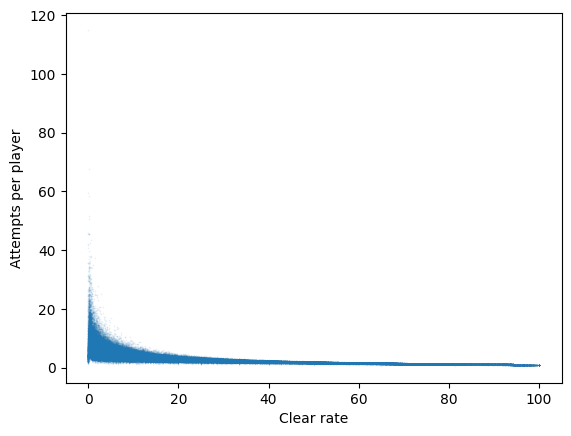

In [53]:
print(df["clear_rate"])
plt.scatter(df["clear_rate"], df["attempts"] / df["plays"], s=1, lw=0.1, alpha=0.1)
plt.ylabel("Attempts per player")
plt.xlabel("Clear rate")

plt.show()

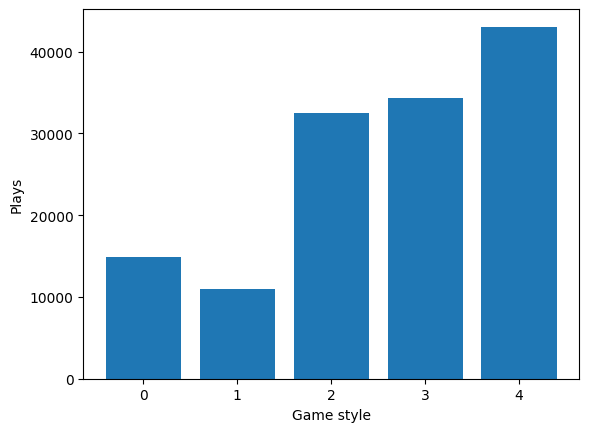

In [70]:
counts = [(df["gamestyle"] == i).sum() for i in range(5)]
plt.bar(range(5), counts)
plt.xlabel("Game style")
plt.ylabel("Plays")

plt.show()

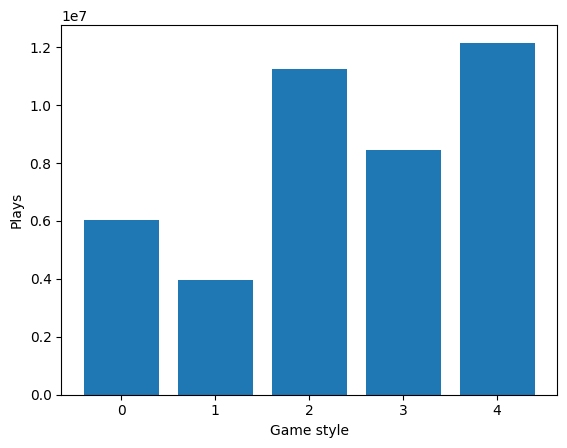

In [71]:
counts = [df[(df["gamestyle"] == i)]["plays"].sum() for i in range(5)]
plt.bar(range(5), counts)
plt.xlabel("Game style")
plt.ylabel("Plays")

plt.show()

[[14890     0     0]
 [11023     0     0]
 [32490     0     0]
 [34309     0     0]
 [43052     0     0]]


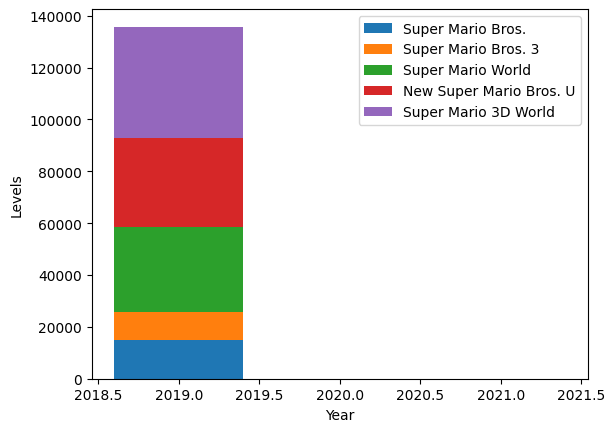

In [53]:
years = [2019, 2020, 2021]
gamestyles = [0, 1, 2, 3, 4]
gamestyles_labels = ["Super Mario Bros.", "Super Mario Bros. 3", "Super Mario World", "New Super Mario Bros. U", "Super Mario 3D World"]

counts = [[((df["uploaded"].dt.year == yr) & (df["gamestyle"] == gs)).sum() for yr in years] for gs in gamestyles]
counts = np.array(counts)
print(counts)

bottom = 0
for j in range(len(gamestyles)):
  plt.bar(years, counts[j], bottom=bottom, label=gamestyles_labels[j])
  bottom += counts[j]
plt.xlabel("Year")
plt.ylabel("Levels")
plt.legend()

plt.show()

In [4]:
# Level objects analysis
def analyze_level(level_data):
  level = Level(KaitaiStream(BytesIO(zlib.decompress(level_data))))
  # for obj in level.overworld.objects:
  #   with lock:
  #     counts[obj.id] = counts.get(obj.id, 0) + 1
  with lock:
    for i in range(level.overworld.object_count):
      obj = level.overworld.objects[i]
      counts[obj.id] = counts.get(obj.id, 0) + 1

# def analyze_level(counts, level_data_list):
#   for level_data in level_data_list:
#     level = Level(KaitaiStream(BytesIO(zlib.decompress(level_data))))
#     for i in range(level.overworld.object_count):
#       obj = level.overworld.objects[i]
#       counts[obj.id] = counts.get(obj.id, 0) + 1

In [13]:
# No multithreading
counts = {}
for level_data in df["level_data"][:100]:
  analyze_level(level_data)
print(counts)

{<ObjId.block: 4>: 2541, <ObjId.question_block: 5>: 442, <ObjId.spring: 10>: 73, <ObjId.hard_block: 6>: 2362, <ObjId.door: 55>: 106, <ObjId.burner: 54>: 47, <ObjId.pipe: 9>: 221, <ObjId.spikes: 43>: 790, <ObjId.mushroom_platform: 14>: 62, <ObjId.lift: 11>: 20, <ObjId.red_coin: 92>: 15, <ObjId.ice_block: 63>: 280, <ObjId.coin: 8>: 2215, <ObjId.goomba: 0>: 268, <ObjId.koopa: 1>: 131, <ObjId.piranha_flower: 2>: 96, <ObjId.checkpoint_flag: 90>: 19, <ObjId.one_up: 33>: 12, <ObjId.bridge: 17>: 27, <ObjId.semisolid_platform: 16>: 75, <ObjId.cheep_cheep: 56>: 64, <ObjId.hidden_block: 29>: 133, <ObjId.thwomp: 12>: 92, <ObjId.arrow: 66>: 56, <ObjId.skewer: 83>: 14, <ObjId.on_off_block: 99>: 57, <ObjId.dotted_line_block: 100>: 328, <ObjId.saw: 68>: 42, <ObjId.bullet_bill_blaster: 13>: 49, <ObjId.big_coin: 70>: 60, <ObjId.lava_bubble: 60>: 85, <ObjId.rocky_wrench: 58>: 20, <ObjId.steep_slope: 88>: 195, <ObjId.fast_conveyor_belt: 53>: 72, <ObjId.one_way: 67>: 15, <ObjId.slight_slope: 87>: 92, <ObjI

In [ ]:
n_thr = 16

# def init():
#   global counts
#   counts = {}

counts = {}

lock = Lock()

with ThreadPool(n_thr) as pool:
  pool.map(analyze_level, df["level_data"][:100])
  pool.close()
  pool.join()

print(counts)

# print("Summing...")

# final_counts = res[0]
# for c in res[1:]:
#   for k in c:
#     final_counts[k] = final_counts.get(k, 0) + c[k]
# print(final_counts)

{<ObjId.block: 4>: 2541, <ObjId.question_block: 5>: 442, <ObjId.big_mushroom: 44>: 147, <ObjId.pipe: 9>: 221, <ObjId.hard_block: 6>: 2362, <ObjId.door: 55>: 106, <ObjId.burner: 54>: 47, <ObjId.spikes: 43>: 790, <ObjId.mushroom_platform: 14>: 62, <ObjId.lift: 11>: 20, <ObjId.red_coin: 92>: 15, <ObjId.ice_block: 63>: 280, <ObjId.coin: 8>: 2215, <ObjId.goomba: 0>: 268, <ObjId.spring: 10>: 73, <ObjId.cannon: 47>: 62, <ObjId.snake_block: 84>: 16, <ObjId.p_switch: 18>: 11, <ObjId.spiny: 25>: 91, <ObjId.note_block: 23>: 85, <ObjId.donut_block: 21>: 188, <ObjId.cloud: 22>: 352, <ObjId.dry_bones: 46>: 9, <ObjId.fire_flower: 34>: 13, <ObjId.piranha_flower: 2>: 96, <ObjId.spike_top: 40>: 16, <ObjId.steep_slope: 88>: 195, <ObjId.big_coin: 70>: 60, <ObjId.checkpoint_flag: 90>: 19, <ObjId.muncher: 57>: 20, <ObjId.on_off_block: 99>: 57, <ObjId.dotted_line_block: 100>: 328, <ObjId.seesaw: 91>: 18, <ObjId.swinging_claw: 105>: 26, <ObjId.hidden_block: 29>: 133, <ObjId.banzai_bill: 32>: 43, <ObjId.bullet